In [29]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from datasets.image_captioning import *

from utils import load_checkpoint
from models.captioning import CaptionNet

import config

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

from models.compress import HyperpriorWrapper, bmshj2018_hyperprior

%matplotlib inline

In [30]:
config.DEVICE

'cuda'

In [31]:
network = CaptionNet(n_tokens, cnn_feature_size=12288).to(config.DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-4)

In [32]:
load_checkpoint("captions_compressed_8a.pth.tar", network, optimizer, 1e-3)

=> Loading checkpoint


In [33]:
# from models.beheaded_inception3 import beheaded_inception_v3
# inception = beheaded_inception_v3().train(False)

In [34]:
compressor = HyperpriorWrapper(
    bmshj2018_hyperprior(config.COMPRESS_QUALITY, pretrained=True)
    .eval()
    .to(config.DEVICE),
    type="s",
)

In [35]:
def generate_caption(image, caption_prefix=("#START#",), t=1, sample=True, max_len=100):

    assert (
        isinstance(image, np.ndarray)
        and np.max(image) <= 1
        and np.min(image) >= 0
        and image.shape[-1] == 3
    )

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(config.DEVICE)

        # vectors_8x8, vectors_neck, logits = inception(image[None])
        vectors_neck = compressor.compress(image[None])
        vectors_neck = F.avg_pool2d(vectors_neck, kernel_size=2)
        vectors_neck = torch.flatten(vectors_neck, start_dim=1)
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(
                vectors_neck.to(config.DEVICE), prefix_ix.to(config.DEVICE)
            )[0, -1]
            next_word_probs = (
                F.softmax(next_word_logits, dim=-1).data.detach().cpu().numpy()
            )
            next_word_probs = next_word_probs.clip(0)
            assert len(next_word_probs.shape) == 1, "probs must be one-dimensional"
            next_word_probs = next_word_probs**t / np.sum(
                next_word_probs**t
            )  # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

a woman with glasses with hair with hair is eating a pizza with his hair while holding a video game of pizza in his hand while holding a cell phone while standing in the living room holding a laptop computer in front of a laptop computer on the desk with a laptop computer on the desk with a laptop computer on the desk and a desk with a laptop on the table and a table with a table and a table with a table , a table , and a table with a glass of wine and a glass
picture of computer keyboard .
are of are are are black-and-white of day day of are are formation of are day day day of full of day of city street of filled with street with white street with a wall with a white background .
the horses elephant elephant elephant .
a plate is plate is plate of food is oranges and vegetables are displayed and vegetables are on a table .
a #UNK# at a ball at a ball at a ball at a ball at a ball at a ball at a tennis court with a racket on a court with a tennis racket on a court with a tennis racket 

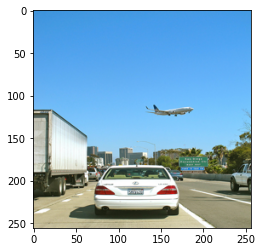

In [39]:
# sample image
# path = 'datasets/image_captioning/flickr30k_images/flickr30k_images/'
path = "datasets/image_captioning/coco2017/"
image = random.choice(os.listdir(path))
img = plt.imread(os.path.join(path, image))
img = Image.fromarray(img).resize((256, 256))
img = np.array(img).astype("float32") / 255.0
plt.imshow(img)
for i in range(10):
    print(" ".join(generate_caption(img, t=5.0)[1:-1]))